# Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
%matplotlib inline

# Implementation of Linear Regression

In [2]:
class LinearRegression:
    '''
    Implementation of Linear Regression algorithm
        
    Arguements:
    algo (optional): 'normal_eq' / 'batch_grad_descent' / 'stochastic_grad_descent' / 'newton_method'
        Type of algorithm to be used for linear regression (default: 'normal_eq')
    num_iter (optional): Max number of iterations (default value: 5000) (if convergence is acheived before this number,
    algorithm will stop) (Ignored when 'normal_eq' is algo)
    learning_rate (optional): Value for learning rate (default value: 0.001)
    epsilon (optional): Threshold of square error difference between costs of consecutive iterations used to
    decide convergence of gradient descent algorithm (default value = 1e-04)
    verbose (optional): Boolean value which decide whether the output of the algorithm will be verbose (default value = False)
    initialization (optional): 'zeros' / 'random', parameter used for method of initialization of parameter matrix
        (default value = 'zeros')
    lmbda (optional): Regularization parameter (default value = 0)
    
    Outputs:
    theta: Parameter matrix of shape (n, 1)
    costs: A dictionary with iteration number key and corresponding cost as value    
    '''
    def __init__(self, algo = 'normal_eq', num_iter = 5000, learning_rate = 0.001,
                  epsilon = 1e-04, verbose = False, initialization = 'zeros', lmbda = 0):
        self.num_iter = num_iter
        self.algo = algo
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.verbose = verbose
        self.initialization = initialization
        self.lmbda = lmbda
        
    def fit(self, X, y, dummy_feature_add = False):
        '''
        This function / method fits parameters of linear regression with training data X and y.
        X: Feature matrix of shape (m, n), m = number of training examples, n = number of features
        y: Output / label vector of shape (m, 1)
        dummy_feature_add: Boolean parameter to decide whether dummy feature need to be added in the feature matrix
            Default value: False
        '''
        self.X = X
        self.m = X.shape[0]
        # Convert 1D array to 2D array
        if np.ndim(self.X) == 1:
            self.X = self.X.reshape(-1, 1)
        # Function which will add dummy feature to the feature matrix
        if dummy_feature_add:
            self.X = add_dummy(self.X)
        self.y = y.reshape(self.m, 1)
        self.n = self.X.shape[1]
        
        # Intitialize paramters as per initialization criterion
        if self.initialization == 'zeros':
            self.theta = np.zeros(shape = (self.n, 1))
        else:
            self.theta = np.random.rand(self.n, 1)
        
        if self.algo != 'normal_eq':
            self.hypothesis_calc()
            cost = self.cost_calc()
            self.costs = {}
            self.costs[0] = cost
            if self.verbose:
                print('Initial cost: {}'.format(cost))
        
        # Implementation of batch gradient descent algorithm
        if self.algo == 'batch_grad_descent':
            for i in range(self.num_iter):
                self.hypothesis_calc()
                self.update_gradients()
                if self.verbose:
                    if ((i + 1) % 10) == 0:
                        cost = self.cost_calc()
                        print('Iteration: {}, Cost: {}'.format(i+1, cost))
                        self.costs[i+1] = cost
                if len(self.costs) >= 2:
                    if self.convergence_check():
                        print('Alogorithm has converged')
                        break
                        
        # Implementation of stochastic gradient descent algorithm
        elif self.algo == 'stochastic_grad_descent':
            for i in range(self.num_iter):
                index = i % (len(self.y) - 1)
                for j in range(self.n):
                    self.theta[j][0] -= (self.learning_rate * (self.h[index] - self.y[index]) * self.X[index, :][j] +
                                         self.lmbda * self.theta[j][0])
                self.hypothesis_calc()
                if self.verbose:
                    if ((i + 1) % 10) == 0:
                        cost = self.cost_calc()
                        print('Iteration: {}, Cost: {}'.format(i+1, cost))
                        self.costs[i+1] = cost
                if len(self.costs) >= 2:
                    if self.convergence_check():
                        print('Alogorithm has converged')
                        break
            
        # Implementation of linear regression using Normal Equation
        elif self.algo == 'normal_eq':
            matrix_1 = np.linalg.inv(np.matmul(np.transpose(self.X), self.X) + self.lmbda)
            matrix_2 = np.matmul(matrix_1, np.transpose(self.X))
            self.theta = np.matmul(matrix_2, self.y)
            
        # Implementation of linear regression using Newton's method
        elif self.algo == 'newton_method':
            for i in range(self.num_iter):
                mat1 = np.linalg.inv(np.matmul(self.X.T, self.X) + self.lmbda)
                mat2 = (np.matmul(np.matmul(self.X.T, self.X), self.theta) - (np.matmul(self.X.T, self.y)) +
                        (self.lmbda * self.theta))
                self.theta = self.theta - np.matmul(mat1, mat2)
                self.hypothesis_calc()
                if self.verbose:
                    cost = self.cost_calc()
                    print('Iteration: {}, Cost: {}'.format(i+1, cost))
                    self.costs[i+1] = cost
                if len(self.costs) >= 2:
                    if self.convergence_check():
                        print('Alogorithm has converged')
                        break
            
    def update_gradients(self):
        '''
        This function / method updates parameter matrix (theta) when batch gradient descent algorithm is used for
        optimization of parameters
        '''
        int_term = np.nansum(np.multiply((self.h - self.y), self.X), axis = 0)
        int_term = int_term.reshape((self.n,1))
        self.theta = self.theta - (self.learning_rate * int_term) - (self.lmbda * self.theta)
        
    def cost_calc(self):
        '''
        This function / method calculates cost.

        Returns:
        cost: Calculated cost based on hypothesis (h) and output matrix (y)
        '''
        cost = 0.5 * np.nansum(np.square((self.h-self.y))) + (0.5 * self.lmbda * (np.linalg.norm(self.theta) ** 2))
        return cost
    
    def hypothesis_calc(self):
        '''
        This function / method calculates hypothesis matrix.

        Returns: This function does not return a value. It updates hypothesis attribute of the class.
        h (hypothesis attribute of class): Hypothesis matrix of shape (m, 1)
        '''
        self.h = np.sum(np.transpose(self.theta) * self.X, axis = 1)
        self.h = self.h.reshape((self.m, 1))
        
    def convergence_check(self):
        '''
        This function / method checks convergence of the algorithm.

        Returns:
        Boolean (True / False) value of whether algorithm has been converged
        '''
        last_two_elem = list(self.costs.values())[-2:]
        error = (last_two_elem[0] - last_two_elem[1]) ** 2
        return error < self.epsilon
    
    def predict(self, X_pred, dummy_feature_add = False):
        '''
        This function / method calculates output (y) using fitted parameters for given feature matrix X_pred.

        Arguements:
        X_pred: Feature matrix of shape (m, n), m = number of examples, n = number of features
        dummy_feature_add: Boolean parameter to decide whether dummy feature need to be added in the feature matrix
            Default value: False
        
        Returns:
        y_pred: Predicted output matrix of shape (m, 1)
        '''
        if np.ndim(X_pred) == 1:
            X_pred = X_pred.reshape(-1, 1)
        if dummy_feature_add:
            X_pred = add_dummy(X_pred)
        y_pred = np.sum(np.multiply(np.transpose(self.theta), X_pred), axis = 1)
        y_pred = y_pred.reshape((X_pred.shape[0], 1))    
        return y_pred
    
    def r_square(self, y_true, y_pred):
        '''
        This function calculates r-square value of the linear regression model.

        Arguements:
        y_true: True output / label matrix of shape (m, 1), m = number of examples
        y_pred: Predicted output matrix of shape (m, 1)

        Returns:
        r_square: r_square_value of the linear regression model rounded to 3 digits

        '''
        y_true = y_true.reshape(-1, 1)
        y_mean = np.mean(y_true)
        ss_total = np.sum(np.square(y_true - y_mean))
        ss_res = np.sum(np.square(y_true - y_pred))
        r_square = round((1 - (ss_res / ss_total)), 3)
        return r_square
    
def add_dummy(X):
    '''
    This function adds dummy feature (x0 = 1) to the feature matrix.
    '''
    x_0 = np.ones(shape = (X.shape[0], 1))
    X = np.concatenate((x_0, X), axis = 1)
    return X

# Import the synthetic dataset with only one feature
Synthetic dataset taken from Kaggle has been used to test implementation of Linear Regression

In [3]:
# The dataset for this analysis is taken from: https://www.kaggle.com/andonians/random-linear-regression
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Remove blank rows from the data
train = train.dropna()
test = test.dropna()

# Scale Train and Test dataset

In [4]:
# Scale / normalize the train and test dataframes
max_value = train['x'].max()
min_value = train['x'].min()

train_scaled = pd.DataFrame()
train_scaled['x'] = (train['x'] - min_value) / (max_value - min_value)
train_scaled['y'] = train['y']

test_scaled = pd.DataFrame()
test_scaled['x'] = (test['x'] - min_value) / (max_value - min_value)
test_scaled['y'] = test['y']

# Convert the dataframe to numpy arrays
x_train, y_train = train_scaled['x'].to_numpy(), train_scaled['y'].to_numpy()
x_test, y_test = test_scaled['x'].to_numpy(), test_scaled['y'].to_numpy()

# Linear Regression with different methods for optimization of parameters
1. Normal Equation Method
2. Batch Gradient Descent Method
3. Stochastic Gradient Descent Method
4. Newton's Method

In [5]:
# Linear regression with normal equation and without regularization
lr1 = LinearRegression()
lr1.fit(x_train, y_train, dummy_feature_add = True)
y_test_pred_normal_eq = lr1.predict(x_test, dummy_feature_add = True)
r_square_norm = lr1.r_square(y_test, y_test_pred_normal_eq)
print('R-square value on test dataset is {}'.format(r_square_norm))

R-square value on test dataset is 0.989


In [6]:
# Linear regression with batch gradient descent algorithm for optimization (without regularization)
lr2 = LinearRegression(algo = 'batch_grad_descent', learning_rate=0.0001, verbose = False)
lr2.fit(x_train, y_train, dummy_feature_add = True)
y_test_pred_batch = lr2.predict(x_test, dummy_feature_add = True)
r_square_batch = lr2.r_square(y_test, y_test_pred_batch)
print('R-square value on test dataset is {}'.format(r_square_batch))

R-square value on test dataset is 0.989


In [7]:
# Linear regression with stochastic gradient descent algorithm for optimization (without regularization)
lr3 = LinearRegression(algo = 'stochastic_grad_descent', learning_rate=0.005, num_iter = 60000, verbose = False)
lr3.fit(x_train, y_train, dummy_feature_add = True)
y_test_pred_stochastic = lr3.predict(x_test, dummy_feature_add = True)
r_square_stochastic = lr3.r_square(y_test, y_test_pred_stochastic)
print('R-square value on test dataset is {}'.format(r_square_stochastic))

R-square value on test dataset is 0.989


In [8]:
# Linear regression with Newton's method for optimization (without regularization)
lr4 = LinearRegression(algo = 'newton_method', verbose = False)
lr4.fit(x_train, y_train, dummy_feature_add = True)
y_test_pred_newton = lr4.predict(x_test, dummy_feature_add = True)
r_square_newton = lr4.r_square(y_test, y_test_pred_newton)
print('R-square value on test dataset is {}'.format(r_square_newton))

R-square value on test dataset is 0.989


# Effect of regularization

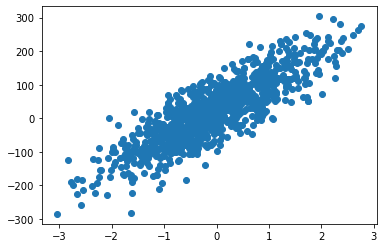

In [9]:
'''Lets create another synthetic dataset (noisy dataset to demonstrate effect of regularization)
using scikit learn'''
X, y = make_regression(n_samples = 1000, n_features = 1, n_informative = 1, bias = 25,
                       noise = 50, tail_strength = 10, random_state = 0)
plt.scatter(X, y);
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

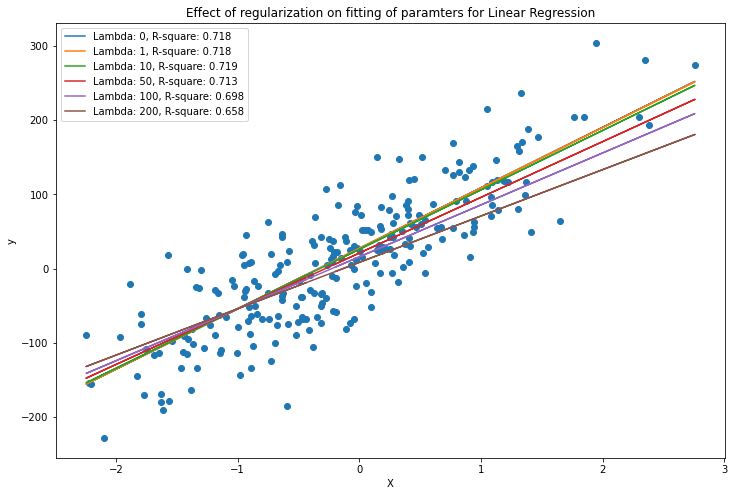

In [10]:
lmbda_list = [0, 1, 10, 50, 100, 200]
y_pred_list = []
r_square_list = []
for i in lmbda_list:
    lr = LinearRegression(lmbda = i)
    lr.fit(X_train, y_train, dummy_feature_add = True)
    y_pred_list.append(lr.predict(X_test, dummy_feature_add = True))
    r_square_list.append(lr.r_square(y_test, y_pred_list[-1]))
    
plt.figure(figsize = (12, 8))
for i in range(len(y_pred_list)):
    plt.plot(X_test, y_pred_list[i], label = 'Lambda: {}, R-square: {}'.format(lmbda_list[i], r_square_list[i]))
plt.xlabel('X')
plt.ylabel('y')
plt.title('Effect of regularization on fitting of paramters for Linear Regression')
plt.scatter(X_test, y_test)
plt.legend()